## Optimized data input pipelines

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## Imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import os
import sys
import time
import functools
import numpy as np
import pickle as pkl
from pprint import pprint
from typing import Callable, Dict, List, Optional, TypeVar, Any

# logging
import logging
logging.disable(logging.WARNING)

#python warning 
import warnings
warnings.filterwarnings("ignore")

# tensorflow
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp

# tf-agents
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.metrics import export_utils
from tf_agents.policies import policy_saver
from tf_agents.trajectories import trajectory
from tf_agents.train.utils import strategy_utils
from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.bandits.specs import utils as bandit_spec_utils

from tf_agents.replay_buffers import tf_uniform_replay_buffer

# google cloud
from google.cloud import aiplatform, storage, bigquery

GCS_SDK_VERSION = storage.__version__
BQ_SDK_VERSION  = bigquery.__version__
AIP_SDK_VERSION = aiplatform.__version__

print(f'storage SDK version   : {GCS_SDK_VERSION}')
print(f'bigquery SDK version  : {BQ_SDK_VERSION}')
print(f'vertex_ai SDK version : {AIP_SDK_VERSION}')

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

storage SDK version   : 2.14.0
bigquery SDK version  : 3.25.0
vertex_ai SDK version : 1.71.0


In [7]:
# this repo
import sys
sys.path.append("../..")

from src.utils import train_utils as train_utils
from src.utils import reward_factory as reward_factory
from src.agents import rfa_utils as rfa_utils
from src.data import data_utils as data_utils
from src.data import data_config as data_config
from src.networks import encoding_network as emb_features
from src.agents import agent_factory as agent_factory

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
device = cuda.get_current_device()
device.reset()
gc.collect()

# print(f"device: {device.name.decode()}")

14

In [8]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# bigquery client
bqclient = bigquery.Client(project=PROJECT_ID,)

## Data

**TODOs**
* See API specs for following classes:
  * [HParam](https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/summary_v2.py#L278), 
  * [Metric](https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/summary_v2.py#L545),
  * `KerasCallback`
  
* see [internal examples](https://source.corp.google.com/piper///depot/google3/third_party/py/tf_agents/google/distributed/examples/train_dqn_multi_gpu.py) for guidance for distributed train jobs
* see internal example for [dataset anlsysis](https://source.corp.google.com/piper///depot/google3/commerce/delivery/recommendation/shop_rl/python/topk_off_policy_reinforce/dataset_analysis.ipynb)
Internal reference
* [Tensorflow Trainer Inputs](https://source.corp.google.com/piper///depot/google3/learning/tfx/pipeline/trainer/tensorflow_trainer_inputs.py;l=594?q=HParams&sq=package:piper%20file:%2F%2Fdepot%2Fgoogle3%20-file:google3%2Fexperimental)

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [10]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")
# !gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m


In [11]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:3] # subset

train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'prog

### get vocab

In [12]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

# vocab_dict['user_occupation_text']

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



### defining HPARAMS

In [13]:
print(f"USER_FEATURE_NAMES  : {data_utils.USER_FEATURE_NAMES}")
print(f"MOVIE_FEATURE_NAMES : {data_utils.MOVIE_FEATURE_NAMES}")

USER_FEATURE_NAMES  : ['user_id', 'user_age', 'user_occupation_text', 'target_rating_timestamp', 'user_zip_code', 'user_gender']
MOVIE_FEATURE_NAMES : ['target_movie_id', 'target_movie_title', 'target_movie_year', 'target_movie_genres']


In [14]:
# agent config
AGENT_TYPE      = 'NeuralLinUCB' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'
AGENT_ALPHA     = 0.1
EPSILON         = 0.01
LR              = 0.05
EPS_PHASE_STEPS = 1000

# data config
NUM_ACTIONS            = 2
BATCH_SIZE             = 128
EVAL_BATCH_SIZE        = 1
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 12
MV_EMBEDDING_SIZE      = 16
NUM_GLOBAL_FEATURES    = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES       = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
ENCODING_DIM           = 1

# feature dims
GLOBAL_DIM = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
PER_ARM_DIM = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

# encoder layers
GLOBAL_LAYERS = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]

FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1]
COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    int(FIRST_COMMON_LAYER/4)
]
NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

# hparams dict
HPARAMS = {
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "global_emb_size": GLOBAL_EMBEDDING_SIZE,
    "arm_emb_size": MV_EMBEDDING_SIZE,
    "global_dim": GLOBAL_DIM,
    "per_arm_dim": PER_ARM_DIM,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "num_oov_buckets": NUM_OOV_BUCKETS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'arm_emb_size': 16,
 'batch_size': 128,
 'common_layers': [34, 8],
 'encoding_dim': 8,
 'eval_batch_size': 1,
 'global_dim': 72,
 'global_emb_size': 12,
 'global_layers': [72, 36, 18],
 'model_type': 'NeuralLinUCB',
 'network_type': 'commontower',
 'num_actions': 2,
 'num_oov_buckets': 1,
 'per_arm_dim': 64,
 'per_arm_layers': [64, 32, 16]}


## parse sequence examples


`common layers`
* layer sizes for the final tower
* The network that takes as input the concatenation of the outputs of the global and the arm networks
* hidden layers ideally divisible by 8, e.g., [16, 32, 64, 128, 256, 512]

In [68]:
# HPARAMS

{'batch_size': 128,
 'eval_batch_size': 1,
 'num_actions': 2,
 'global_emb_size': 12,
 'arm_emb_size': 16,
 'global_dim': 72,
 'per_arm_dim': 64,
 'global_layers': [72, 36, 18],
 'per_arm_layers': [64, 32, 16],
 'common_layers': [34, 8],
 'num_oov_buckets': 1,
 'model_type': 'NeuralLinUCB',
 'network_type': 'commontower',
 'encoding_dim': 8}

In [16]:
# x

In [17]:
def _get_global_feature_dict(input_features):
    """
    Return list of global features.
    """
    global_feature_names = data_utils.USER_FEATURE_NAMES
    global_features = {}
    for global_feature in global_feature_names:
        if global_feature in input_features:
            global_features[global_feature] = input_features[global_feature]
        else:
            print('Missing global feature %s', global_feature)
    return global_features

global_features = _get_global_feature_dict(x)
pprint(global_features)

{'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'programmer'], dtype=object)>,
 'user_zip_code': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'87505'], dtype=object)>}


In [18]:
def _get_per_arm_feature_dict(input_features):
    """
    Returns a dictionary mapping feature key to per arm features.
    """
    per_arm_feature_names = data_utils.MOVIE_FEATURE_NAMES
    arm_features = {}
    for per_arm_feature in per_arm_feature_names:
        if per_arm_feature in input_features:
            arm_features[per_arm_feature] = input_features[per_arm_feature]
        else:
            print('Missing per arm feature %s', per_arm_feature)
    return arm_features

arm_features = _get_per_arm_feature_dict(x)
pprint(arm_features)

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>}


### _EmbeddingConfig

In [19]:
import attr

@attr.s
class _EmbeddingConfig(object):
    feature_key = attr.ib()
    dtype = attr.ib()
    embedding_dim = attr.ib()
    input_shape = attr.ib()
    vocab_key = attr.ib()
    transform = attr.ib()
    output_seq_len = attr.ib()

#### global embed config

In [20]:
global_embedding_configs = [
    # global context features
    _EmbeddingConfig(
        feature_key = "user_id", 
        dtype = tf.string, 
        embedding_dim = HPARAMS["global_emb_size"],
        input_shape = (1,),
        vocab_key = "user_id",
        transform = "StringLookup",
        output_seq_len = None
    ),
    _EmbeddingConfig(
        feature_key = "user_age", 
        dtype = tf.int64,
        embedding_dim = HPARAMS["global_emb_size"],
        input_shape = (1,),
        vocab_key = "user_age_vocab",
        transform = "IntegerLookup",
        output_seq_len = None
    ),
    
#     _EmbeddingConfig(
#         feature_key = 'user_occupation_text', 
#         dtype = tf.string,
#         embedding_dim = HPARAMS['global_emb_size'],
#     ),
    
    _EmbeddingConfig(
        feature_key = 'target_rating_timestamp', 
        dtype = tf.int64,
        embedding_dim = HPARAMS['global_emb_size'],
        input_shape = (1,),
        vocab_key = "timestamp_buckets",
        transform = "Discretization",
        output_seq_len = None
    ),
    
#     _EmbeddingConfig(
#         feature_key = 'user_gender', 
#         dtype = tf.string,
#         embedding_dim = HPARAMS['global_emb_size'],
#     ),
#     _EmbeddingConfig(
#         feature_key = 'user_zip_code', 
#         dtype = tf.int64,
#         embedding_dim = HPARAMS['global_emb_size'],
#     ),

]

global_embedding_configs

[_EmbeddingConfig(feature_key='user_id', dtype=tf.string, embedding_dim=12, input_shape=(1,), vocab_key='user_id', transform='StringLookup', output_seq_len=None),
 _EmbeddingConfig(feature_key='user_age', dtype=tf.int64, embedding_dim=12, input_shape=(1,), vocab_key='user_age_vocab', transform='IntegerLookup', output_seq_len=None),
 _EmbeddingConfig(feature_key='target_rating_timestamp', dtype=tf.int64, embedding_dim=12, input_shape=(1,), vocab_key='timestamp_buckets', transform='Discretization', output_seq_len=None)]

#### arm embed config

In [21]:
arm_embedding_configs = [
#     _EmbeddingConfig(
#         feature_key = 'target_movie_id', 
#         dtype = tf.string,
#         embedding_dim = HPARAMS['arm_emb_size'],
#     ),
#     _EmbeddingConfig(
#         feature_key = 'target_movie_year', 
#         dtype = tf.int64,
#         embedding_dim = HPARAMS['arm_emb_size'],
#     ),
    _EmbeddingConfig(
        feature_key = 'target_movie_title', 
        dtype = tf.string,
        embedding_dim = HPARAMS['arm_emb_size'],
        input_shape = (1,),
        vocab_key = "movie_title",
        transform = "TextVectorization",
        output_seq_len = None
    ),
    _EmbeddingConfig(
        feature_key = 'target_movie_genres', 
        dtype = tf.string,
        embedding_dim = HPARAMS['arm_emb_size'],
        input_shape = (data_config.MAX_GENRE_LENGTH,1),
        vocab_key = "movie_genre",
        transform = "TextVectorization",
        output_seq_len = data_config.MAX_GENRE_LENGTH
    ),
]
arm_embedding_configs

[_EmbeddingConfig(feature_key='target_movie_title', dtype=tf.string, embedding_dim=16, input_shape=(1,), vocab_key='movie_title', transform='TextVectorization', output_seq_len=None),
 _EmbeddingConfig(feature_key='target_movie_genres', dtype=tf.string, embedding_dim=16, input_shape=(10, 1), vocab_key='movie_genre', transform='TextVectorization', output_seq_len=10)]

### processing functions

In [22]:
def _get_global_feature_preprocess_layer(embedding_configs, hparams):
    """Returns global feature preprocessing layer."""

    global_inputs = []
    global_features = []

    for embed_config in embedding_configs:
        input_feature = tf.keras.Input(
            name=embed_config.feature_key,
            shape=embed_config.input_shape,
            dtype=embed_config.dtype
        )
        vocab = vocab_dict[embed_config.vocab_key]
        max_tokens = len(vocab_dict[embed_config.vocab_key]) + hparams['num_oov_buckets']

        # get lookup layer
        if embed_config.transform == "StringLookup":
            lookup = tf.keras.layers.StringLookup(
                max_tokens=max_tokens,
                num_oov_indices=hparams['num_oov_buckets'],
                mask_token=None,
                vocabulary=vocab
            )
        if embed_config.transform == "IntegerLookup":
            lookup = tf.keras.layers.IntegerLookup(
                vocabulary=vocab, 
                num_oov_indices=hparams['num_oov_buckets'], 
                oov_value=0
            )
        if embed_config.transform == "Discretization":
            lookup = tf.keras.layers.Discretization(vocab.tolist())
        if embed_config.transform == "TextVectorization":
            lookup = tf.keras.layers.TextVectorization(
                ngrams=2,
                vocabulary=vocab,
                output_mode="int",
                output_sequence_length=embed_config.output_seq_len if embed_config.output_seq_len else None
            )
        # build emb model
        ind_tensor = lookup(input_feature)
        embedding_input = tf.keras.layers.Embedding(
            input_dim=max_tokens, 
            output_dim=embed_config.embedding_dim
        )(ind_tensor)
        embedding_input = tf.reduce_sum(embedding_input, axis=-2)

        global_inputs.append(input_feature)
        global_features.append(embedding_input)

    global_outputs = tf.keras.layers.concatenate(global_features, axis=-1)
    return tf.keras.Model(inputs=global_inputs, outputs=global_outputs, name="global_embed_model",)

In [23]:
test_global_layer = _get_global_feature_preprocess_layer(
    embedding_configs=global_embedding_configs, 
    hparams=HPARAMS
)
test_global_layer

In [24]:
test_global_layer.summary()

Model: "global_embed_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_age (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 target_rating_timestamp (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['user_id[0][

In [25]:
def _get_arm_feature_preprocess_layer(embedding_configs, hparams):
    """Returns arm feature preprocessing layer."""

    arm_inputs = []
    arm_features = []

    for embed_config in embedding_configs:
        input_feature = tf.keras.Input(
            name=embed_config.feature_key,
            shape=embed_config.input_shape,
            dtype=embed_config.dtype
        )
        vocab = vocab_dict[embed_config.vocab_key]
        max_tokens = len(vocab_dict[embed_config.vocab_key]) + hparams['num_oov_buckets']

        # get lookup layer
        if embed_config.transform == "StringLookup":
            lookup = tf.keras.layers.StringLookup(
                max_tokens=max_tokens,
                num_oov_indices=hparams['num_oov_buckets'],
                mask_token=None,
                vocabulary=vocab
            )
        if embed_config.transform == "IntegerLookup":
            lookup = tf.keras.layers.IntegerLookup(
                vocabulary=vocab, 
                num_oov_indices=hparams['num_oov_buckets'], 
                oov_value=0
            )
        if embed_config.transform == "Discretization":
            lookup = tf.keras.layers.Discretization(vocab.tolist())
        if embed_config.transform == "TextVectorization":
            lookup = tf.keras.layers.TextVectorization(
                ngrams=2,
                vocabulary=vocab,
                output_mode="int",
                output_sequence_length=embed_config.output_seq_len if embed_config.output_seq_len else None
            )
        # build emb model
        ind_tensor = lookup(input_feature)
        embedding_input = tf.keras.layers.Embedding(
            input_dim=max_tokens, 
            output_dim=embed_config.embedding_dim
        )(ind_tensor)
        embedding_input = tf.reduce_sum(embedding_input, axis=-2)
        
        if embed_config.output_seq_len:
            reshape = tf.keras.layers.Reshape([-1, embed_config.embedding_dim])(embedding_input)
            embedding_input = tf.keras.layers.GlobalAveragePooling1D()(reshape)

        arm_inputs.append(input_feature)
        arm_features.append(embedding_input)

    arm_outputs = tf.keras.layers.concatenate(arm_features, axis=-1)
    return tf.keras.Model(inputs=arm_inputs, outputs=arm_outputs, name="arm_embed_model")

In [26]:
test_global_layer = _get_arm_feature_preprocess_layer(
    embedding_configs=arm_embedding_configs, 
    hparams=HPARAMS
)
test_global_layer

In [27]:
test_global_layer.summary()

Model: "arm_embed_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_movie_genres (Input  [(None, 10, 1)]              0         []                            
 Layer)                                                                                           
                                                                                                  
 text_vectorization_1 (Text  (None, 10, 10)               0         ['target_movie_genres[0][0]'] 
 Vectorization)                                                                                   
                                                                                                  
 target_movie_title (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                              

#### tmp debugging - START

In [28]:
# test_embedding_configs = global_embedding_configs
test_embedding_configs = arm_embedding_configs
test_embedding_configs

[_EmbeddingConfig(feature_key='target_movie_title', dtype=tf.string, embedding_dim=16, input_shape=(1,), vocab_key='movie_title', transform='TextVectorization', output_seq_len=None),
 _EmbeddingConfig(feature_key='target_movie_genres', dtype=tf.string, embedding_dim=16, input_shape=(10, 1), vocab_key='movie_genre', transform='TextVectorization', output_seq_len=10)]

In [29]:
hparams = HPARAMS

test_inputs = []
test_features = []

for embed_config in test_embedding_configs:
    input_feature = tf.keras.Input(
        name=embed_config.feature_key,
        shape=embed_config.input_shape,
        dtype=embed_config.dtype
    )
    vocab = vocab_dict[embed_config.vocab_key]
    max_tokens = len(vocab_dict[embed_config.vocab_key]) + hparams['num_oov_buckets']

    # get lookup layer
    if embed_config.transform == "StringLookup":
        lookup = tf.keras.layers.StringLookup(
            max_tokens=max_tokens,
            num_oov_indices=hparams['num_oov_buckets'],
            mask_token=None,
            vocabulary=vocab
        )
    if embed_config.transform == "IntegerLookup":
        lookup = tf.keras.layers.IntegerLookup(
            vocabulary=vocab, 
            num_oov_indices=hparams['num_oov_buckets'], 
            oov_value=0
        )
    if embed_config.transform == "Discretization":
        lookup = tf.keras.layers.Discretization(vocab.tolist())
    if embed_config.transform == "TextVectorization":
        lookup = tf.keras.layers.TextVectorization(
            ngrams=2,
            vocabulary=vocab,
            output_mode="int",
            output_sequence_length=embed_config.output_seq_len if embed_config.output_seq_len else None
        )
    # build emb model
    ind_tensor = lookup(input_feature)
    embedding_input = tf.keras.layers.Embedding(
        input_dim=max_tokens, 
        output_dim=embed_config.embedding_dim
    )(ind_tensor)
    embedding_input = tf.reduce_sum(embedding_input, axis=-2)
    
    if embed_config.output_seq_len:
        reshape = tf.keras.layers.Reshape([-1, embed_config.embedding_dim])(embedding_input)
        embedding_input = tf.keras.layers.GlobalAveragePooling1D()(reshape)

    test_inputs.append(input_feature)
    test_features.append(embedding_input)

print(f"test_inputs  : {test_inputs}")
print(f"test_features : {test_features}")

test_inputs  : [<KerasTensor: shape=(None, 1) dtype=string (created by layer 'target_movie_title')>, <KerasTensor: shape=(None, 10, 1) dtype=string (created by layer 'target_movie_genres')>]
test_features : [<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'tf.math.reduce_sum_5')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'global_average_pooling1d_1')>]


In [30]:
test_outputs = tf.keras.layers.concatenate(test_features, axis=-1)
test_outputs

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'concatenate_2')>

In [31]:
test_arm_features = _get_per_arm_feature_dict(x)
test_arm_features

{'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK']], dtype=object)>}

In [32]:
test_arm_features = train_utils._add_outer_dimension(test_arm_features)
test_arm_features

{'target_movie_id': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'1775']], dtype=object)>,
 'target_movie_title': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'Live Flesh (1997)']], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[1997]])>,
 'target_movie_genres': <tf.Tensor: shape=(1, 1, 10), dtype=string, numpy=
 array([[[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
          b'UNK', b'UNK', b'UNK']]], dtype=object)>}

In [33]:
def example_proto_to_trajectory(
    example_proto,
):
    feature_description = {
        # target/label item features
        'target_movie_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'target_movie_rating': tf.io.FixedLenFeature(shape=(), dtype=tf.float32),
        'target_rating_timestamp': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'target_movie_genres': tf.io.FixedLenFeature(shape=(data_config.MAX_GENRE_LENGTH), dtype=tf.string),
        'target_movie_year': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'target_movie_title': tf.io.FixedLenFeature(shape=(), dtype=tf.string),

        # user - global context features
        'user_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_gender': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_age': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'user_occupation_text': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_zip_code': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
    }
    # single_example = tf.io.parse_single_example(example_proto, feature_description)
    parsed_example = tf.io.parse_single_sequence_example(example_proto, feature_description)
    
    return parsed_example[0]

In [34]:
raw_ds = tf.data.TFRecordDataset(train_files)

parse_example_fn = functools.partial(
    example_proto_to_trajectory)

# Apply tf.transforms.
mapped_ds = raw_ds.map(
    # example_proto_to_trajectory,
    parse_example_fn,
    num_parallel_calls=tf.data.AUTOTUNE
)

for x in mapped_ds.batch(3).take(1):
    pprint(x)

{'target_movie_genres': <tf.Tensor: shape=(3, 10), dtype=string, numpy=
array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK'],
       [b'Comedy', b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK', b'UNK'],
       [b'Comedy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'1775', b'2789', b'2249'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([4., 5., 5.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Live Flesh (1997)', b'American Beauty (1999)',
       b'Happiness (1998)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1997, 1999, 1998])>,
 'target_rating_timestamp': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([974612615, 961944637, 965070782])>,
 'user_age': 

In [35]:
# added_dim_arms = train_utils._add_outer_dimension(x)
# added_dim_arms

embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = HPARAMS["num_oov_buckets"],
    global_emb_size = HPARAMS["global_emb_size"],
    mv_emb_size = HPARAMS["arm_emb_size"],
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

global_features_emb = embs._get_global_context_features(x)
global_features_emb

<tf.Tensor: shape=(3, 72), dtype=float32, numpy=
array([[-0.04725269, -0.02247818,  0.03019897,  0.02699835, -0.03052546,
         0.01273074,  0.03960779,  0.00677725,  0.02686648,  0.02291231,
         0.04663701,  0.01114469, -0.00457801,  0.02666224,  0.03489813,
        -0.01537029,  0.01037034, -0.01223407, -0.00589777, -0.04666452,
         0.01503029,  0.00011026, -0.04264965,  0.00277512,  0.02367094,
        -0.03418346, -0.00561113,  0.00150405,  0.04516334, -0.01694458,
         0.01672823,  0.01024719,  0.03909658, -0.02412204,  0.02220744,
         0.04637592, -0.02599993,  0.02327207, -0.03487455,  0.00971887,
         0.04473395,  0.02672703,  0.0299158 ,  0.04748501, -0.02389319,
        -0.04441757,  0.03811956, -0.01334018, -0.03746833, -0.01954033,
        -0.01895853,  0.04093568, -0.0040126 ,  0.02104631, -0.02297285,
        -0.02413582, -0.03993785,  0.01379604,  0.01468047, -0.04186716,
         0.0104496 , -0.04433557, -0.01393598,  0.03938631,  0.01717475,
  

In [36]:
from tf_agents.bandits.policies import policy_utilities

def _trajectory_fn(element, hparams):
    """Converts a dataset element into a trajectory."""
    global_features_emb = embs._get_global_context_features(element)
    arm_features_emb = embs._get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features_emb)
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            # train_utils._add_outer_dimension(tf.concat(global_features_emb, axis=1))
            train_utils._add_outer_dimension(global_features_emb),
    }
    reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))
    dummy_rewards = tf.zeros([hparams['batch_size'], 1, hparams['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        predicted_rewards_mean=dummy_rewards,
        # bandit_policy_type=tf.zeros([hparams['batch_size'], 1, 1], dtype=tf.int32)
    )
    if hparams['model_type'] == 'NeuralLinUCB':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
    
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward))

In [37]:
x

{'target_movie_genres': <tf.Tensor: shape=(3, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK'],
        [b'Comedy', b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Comedy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'1775', b'2789', b'2249'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([4., 5., 5.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(3,), dtype=string, numpy=
 array([b'Live Flesh (1997)', b'American Beauty (1999)',
        b'Happiness (1998)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1997, 1999, 1998])>,
 'target_rating_timestamp': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([974612615, 961944637, 965070782])>,
 'use

In [38]:
_trajectory_fn(x, hparams=HPARAMS)

Trajectory(
{'action': <tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2]], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(3, 1, 72), dtype=float32, numpy=
array([[[-0.04725269, -0.02247818,  0.03019897,  0.02699835,
         -0.03052546,  0.01273074,  0.03960779,  0.00677725,
          0.02686648,  0.02291231,  0.04663701,  0.01114469,
         -0.00457801,  0.02666224,  0.03489813, -0.01537029,
          0.01037034, -0.01223407, -0.00589777, -0.04666452,
          0.01503029,  0.00011026, -0.04264965,  0.00277512,
          0.02367094, -0.03418346, -0.00561113,  0.00150405,
          0.04516334, -0.01694458,  0.01672823,  0.01024719,
          0.03909658, -0.02412204,  0.02220744,  0.04637592,
         -0.0259

In [47]:
process_trajectory_fn = functools.partial(
    _trajectory_fn,
    hparams=HPARAMS,
)

# Convert dataset to Trajectory objects.
traj_ds = mapped_ds.batch(2).map(
    process_trajectory_fn,
    num_parallel_calls=tf.data.AUTOTUNE
)
# traj_ds = mapped_ds.map(
#     process_trajectory_fn,
#     num_parallel_calls=tf.data.AUTOTUNE
# )

for x in traj_ds.take(1):
    pprint(x)

Trajectory(
{'action': <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[0],
       [0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [2]], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(2, 1, 72), dtype=float32, numpy=
array([[[-0.04725269, -0.02247818,  0.03019897,  0.02699835,
         -0.03052546,  0.01273074,  0.03960779,  0.00677725,
          0.02686648,  0.02291231,  0.04663701,  0.01114469,
         -0.00457801,  0.02666224,  0.03489813, -0.01537029,
          0.01037034, -0.01223407, -0.00589777, -0.04666452,
          0.01503029,  0.00011026, -0.04264965,  0.00277512,
          0.02367094, -0.03418346, -0.00561113,  0.00150405,
          0.04516334, -0.01694458,  0.01672823,  0.01024719,
          0.03909658, -0.02412204,  0.02220744,  0.04637592,
         -0.02599993,  0.02327207, -0.03487455,  0.00

In [49]:
def create_single_tfrecord_ds(
    filename,
    process_example_fn,
    shuffle_buffer_size = 1,
):
    raw_ds = tf.data.TFRecordDataset(filename)
    ds = raw_ds.map(
        process_example_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def create_tfrecord_ds(
    filenames,
    process_example_fn,
    process_trajectory_fn,
    batch_size: int,
    shuffle_buffer_size_per_record: int = 1,
    shuffle_buffer_size: int = 10000,
    num_shards: int = 50,
    cycle_length: int = tf.data.AUTOTUNE,
    block_length: int = 10,
    num_prefetch: int = 10,
    num_parallel_calls: int = 10,
    repeat: bool = True,
    drop_remainder: bool = False
):
    filenames = list(filenames)
    initial_len = len(filenames)
    remainder = initial_len % num_shards
    
    for _ in range(num_shards - remainder):
        filenames.append(
            filenames[np.random.randint(low=0, high=initial_len)]
        )
        
    filenames = np.array(filenames)
    np.random.shuffle(filenames)
    filenames = np.array_split(filenames, num_shards)
    filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
    
    if repeat:
        filename_ds = filename_ds.repeat()
    
    filename_ds = filename_ds.shuffle(len(filenames))
    
    example_ds = filename_ds.interleave(
        functools.partial(
            create_single_tfrecord_ds,
            process_example_fn=process_example_fn,
            shuffle_buffer_size=shuffle_buffer_size_per_record,
        ),
        cycle_length=tf.data.AUTOTUNE,
        block_length=block_length,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    example_ds = example_ds.shuffle(shuffle_buffer_size)
    
    example_ds = example_ds.batch(
        batch_size, 
        drop_remainder=drop_remainder
    ).map(
        process_trajectory_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(num_prefetch)
  
    return example_ds

In [52]:
process_example_fn = functools.partial(
    example_proto_to_trajectory,
)
process_trajectory_fn = functools.partial(
    _trajectory_fn,
    hparams=HPARAMS,
)

train_batch_size=5

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    # num_shards = 10,
    process_example_fn=process_example_fn,
    process_trajectory_fn=process_trajectory_fn,
    batch_size=train_batch_size
)
train_dataset_iterator = iter(train_dataset)

test_trajectory = next(train_dataset_iterator)

print(f"test_traj.action.shape      : {test_trajectory.action.shape}") 
print(f"test_traj.discount.shape    : {test_trajectory.discount.shape}")
print(f"test_traj.reward.shape      : {test_trajectory.reward.shape}")
print(f"test_traj.observation.shape : {test_trajectory.observation['global'].shape}")

test_traj.action.shape      : (5, 1)
test_traj.discount.shape    : (5, 1)
test_traj.reward.shape      : (5, 1)
test_traj.observation.shape : (5, 1, 72)


In [65]:
# test_trajectory

#### tmp debugging - END

### sequence example to trajectory

In [15]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = HPARAMS["num_oov_buckets"],
    global_emb_size = HPARAMS["global_emb_size"],
    mv_emb_size = HPARAMS["arm_emb_size"],
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

In [16]:
def example_proto_to_trajectory(
    example_proto,
):
    feature_description = {
        # target/label item features
        'target_movie_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'target_movie_rating': tf.io.FixedLenFeature(shape=(), dtype=tf.float32),
        'target_rating_timestamp': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'target_movie_genres': tf.io.FixedLenFeature(shape=(data_config.MAX_GENRE_LENGTH), dtype=tf.string),
        'target_movie_year': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'target_movie_title': tf.io.FixedLenFeature(shape=(), dtype=tf.string),

        # user - global context features
        'user_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_gender': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_age': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
        'user_occupation_text': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'user_zip_code': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
    }
    # single_example = tf.io.parse_single_example(example_proto, feature_description)
    parsed_example = tf.io.parse_single_sequence_example(example_proto, feature_description)
    
    return parsed_example[0]

In [17]:
from tf_agents.bandits.policies import policy_utilities

def _trajectory_fn(element, hparams, embs):
    """Converts a dataset element into a trajectory."""
    global_features_emb = embs._get_global_context_features(element)
    arm_features_emb = embs._get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features_emb)
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            # train_utils._add_outer_dimension(tf.concat(global_features_emb, axis=1))
            train_utils._add_outer_dimension(global_features_emb),
    }
    reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))
    dummy_rewards = tf.zeros([hparams['batch_size'], 1, hparams['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        predicted_rewards_mean=dummy_rewards,
        # bandit_policy_type=tf.zeros([hparams['batch_size'], 1, 1], dtype=tf.int32)
    )
    if hparams['model_type'] == 'NeuralLinUCB':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
    
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward))

### create single and interleaved TF Record dataset

In [18]:
def create_single_tfrecord_ds(
    filename,
    process_example_fn,
    shuffle_buffer_size = 1,
):
    raw_ds = tf.data.TFRecordDataset(filename)
    ds = raw_ds.map(
        process_example_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def create_tfrecord_ds(
    filenames,
    process_example_fn,
    process_trajectory_fn,
    batch_size: int,
    shuffle_buffer_size_per_record: int = 1,
    shuffle_buffer_size: int = 10000,
    num_shards: int = 50,
    cycle_length: int = tf.data.AUTOTUNE,
    block_length: int = 10,
    num_prefetch: int = 10,
    num_parallel_calls: int = 10,
    repeat: bool = True,
    drop_remainder: bool = False
):
    filenames = list(filenames)
    initial_len = len(filenames)
    remainder = initial_len % num_shards
    
    for _ in range(num_shards - remainder):
        filenames.append(
            filenames[np.random.randint(low=0, high=initial_len)]
        )
        
    filenames = np.array(filenames)
    np.random.shuffle(filenames)
    filenames = np.array_split(filenames, num_shards)
    filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
    
    if repeat:
        filename_ds = filename_ds.repeat()
    
    filename_ds = filename_ds.shuffle(len(filenames))
    
    example_ds = filename_ds.interleave(
        functools.partial(
            create_single_tfrecord_ds,
            process_example_fn=process_example_fn,
            shuffle_buffer_size=shuffle_buffer_size_per_record,
        ),
        cycle_length=tf.data.AUTOTUNE,
        block_length=block_length,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    example_ds = example_ds.shuffle(shuffle_buffer_size)
    
    # map trajectory
    example_ds = example_ds.batch(
        batch_size, 
        drop_remainder=drop_remainder
    ).map(
        process_trajectory_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(num_prefetch)
  
    return example_ds

### validate dataset functions

In [20]:
process_example_fn = functools.partial(
    example_proto_to_trajectory,
)
process_trajectory_fn = functools.partial(
    _trajectory_fn,
    hparams=HPARAMS,
    embs=embs
)

# train_batch_size=5

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    # num_shards = 10,
    process_example_fn=process_example_fn,
    process_trajectory_fn=process_trajectory_fn,
    batch_size=HPARAMS['batch_size']
)
train_dataset_iterator = iter(train_dataset)

test_trajectory = next(train_dataset_iterator)

print(f"test_traj.action.shape      : {test_trajectory.action.shape}") 
print(f"test_traj.discount.shape    : {test_trajectory.discount.shape}")
print(f"test_traj.reward.shape      : {test_trajectory.reward.shape}")
print(f"test_traj.observation.shape : {test_trajectory.observation['global'].shape}")

test_traj.action.shape      : (256, 1)
test_traj.discount.shape    : (256, 1)
test_traj.reward.shape      : (256, 1)
test_traj.observation.shape : (256, 1, 72)


# Train agent

### new hparams

In [19]:
# agent config
AGENT_TYPE      = 'NeuralLinUCB' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'
AGENT_ALPHA     = 0.1
EPSILON         = 0.01
LR              = 0.05
EPS_PHASE_STEPS = 1000

# data config
NUM_ACTIONS            = 2
BATCH_SIZE             = 128
EVAL_BATCH_SIZE        = 1
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 12
MV_EMBEDDING_SIZE      = 16
NUM_GLOBAL_FEATURES    = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES       = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
ENCODING_DIM           = 1

# feature dims
GLOBAL_DIM = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
PER_ARM_DIM = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

# encoder layers
GLOBAL_LAYERS = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]

FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1]
COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    int(FIRST_COMMON_LAYER/4)
]
NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

# hparams dict
HPARAMS = {
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "global_emb_size": GLOBAL_EMBEDDING_SIZE,
    "arm_emb_size": MV_EMBEDDING_SIZE,
    "global_dim": GLOBAL_DIM,
    "per_arm_dim": PER_ARM_DIM,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "num_oov_buckets": NUM_OOV_BUCKETS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'arm_emb_size': 16,
 'batch_size': 128,
 'common_layers': [34, 8],
 'encoding_dim': 8,
 'eval_batch_size': 1,
 'global_dim': 72,
 'global_emb_size': 12,
 'global_layers': [72, 36, 18],
 'model_type': 'NeuralLinUCB',
 'network_type': 'commontower',
 'num_actions': 2,
 'num_oov_buckets': 1,
 'per_arm_dim': 64,
 'per_arm_layers': [64, 32, 16]}


In [20]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = HPARAMS["num_oov_buckets"],
    global_emb_size = HPARAMS["global_emb_size"],
    mv_emb_size = HPARAMS["arm_emb_size"],
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

process_example_fn = functools.partial(
    example_proto_to_trajectory,
)
process_trajectory_fn = functools.partial(
    _trajectory_fn,
    hparams=HPARAMS,
    embs=embs
)

# train_batch_size=5

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    # num_shards = 10,
    process_example_fn=process_example_fn,
    process_trajectory_fn=process_trajectory_fn,
    batch_size=HPARAMS['batch_size']
)
train_dataset_iterator = iter(train_dataset)

test_trajectory = next(train_dataset_iterator)

print(f"test_traj.action.shape      : {test_trajectory.action.shape}") 
print(f"test_traj.discount.shape    : {test_trajectory.discount.shape}")
print(f"test_traj.reward.shape      : {test_trajectory.reward.shape}")
print(f"test_traj.observation.shape : {test_trajectory.observation['global'].shape}")

test_traj.action.shape      : (128, 1)
test_traj.discount.shape    : (128, 1)
test_traj.reward.shape      : (128, 1)
test_traj.observation.shape : (128, 1, 72)


## Define Bandit Agent

In [21]:
from tf_agents.specs import array_spec

observation_spec = {
    'global': tf.TensorSpec([HPARAMS['global_dim']], tf.float32),
    'per_arm': tf.TensorSpec([HPARAMS['num_actions'], HPARAMS['per_arm_dim']], tf.float32)
}

action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=HPARAMS['num_actions']-1,
    name="action_spec"
)

time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)

reward_spec = {
    "reward": array_spec.ArraySpec(
        shape=[HPARAMS['batch_size']], 
        dtype=np.float32, name="reward"
    )
}
reward_tensor_spec = train_utils.from_spec(reward_spec)

In [22]:
global_step = tf.compat.v1.train.get_or_create_global_step()

agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = True,
    debug_summaries = True,
    # arm_preprocessing_combiner = _get_arm_feature_preprocess_layer,
    # global_preprocessing_combiner = _get_global_feature_preprocess_layer
)
      
agent.initialize()
print(f'agent name : {agent.name}')
print(f'train step : {agent.train_step_counter}')

if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent name : neural_linucb_agent
train step : <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>
Network: commontower


In [23]:
# agent.training_data_spec

## set Vertex Experiment

In [24]:
VERSION = "v7"

In [25]:
EXPERIMENT_NAME   = f'02-new-data-input-{VERSION}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint" # same experiment == same checkpoint
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02-new-data-input-v7
RUN_NAME          : run-20241205-143242

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts


In [26]:
# ====================================================
# TB summary writer
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)
# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    # tf_metrics.NumberOfEpisodes(),
    # tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]

pprint(f"metrics: {metrics}")

# ====================================================
# get checkpoint manager
# ====================================================
print(f"\nsetting checkpoint_manager: {CHECKPT_DIR}\n")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
print(f"train step : {agent.train_step_counter}")
# ====================================================
# policy saver
# ====================================================
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=global_step
)
# saver.signatures

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7f4180107910>]')

setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint

train step : <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>


## train config

In [27]:
# # calculate dataset_size
# print(f"getting size of dataset...")
# dataset_size = train_dataset.reduce(0, lambda x,_: x+1).numpy()
# print(f"dataset_size: {dataset_size}")

In [28]:
NUM_TRAIN_STEPS = 50
CHKPT_INTERVAL  = NUM_TRAIN_STEPS # // 5
LOG_INTERVAL    = 10

train_dataset_iterator = iter(train_dataset)

print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")
print(f"CHKPT_INTERVAL  : {CHKPT_INTERVAL}")
print(f"LOG_INTERVAL    : {LOG_INTERVAL}")

NUM_TRAIN_STEPS : 50
CHKPT_INTERVAL  : 50
LOG_INTERVAL    : 10


### train loop

In [29]:
list_o_loss = []

print(f"starting train loop...")
start_time = time.time()

for i in range(NUM_TRAIN_STEPS):
    
    with train_summary_writer.as_default():

        step = agent.train_step_counter.numpy()
        trajectories = next(train_dataset_iterator)

        # All tensors in experience must be shaped [batch, time, ...] 
        loss = agent.train(experience=trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )

        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )

runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")
checkpoint_manager.save(global_step)
print(f"saved to checkpoint_manager: {CHECKPT_DIR}")
saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")

starting train loop...
step = 0: train loss = 14.84000015258789
step = 10: train loss = 13.329999923706055
step = 20: train loss = 6.75
step = 30: train loss = 2.559999942779541
step = 40: train loss = 1.4199999570846558
train runtime_mins: 5
saved to checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts


#### Inspect Saver and Checkpointer

In [30]:
!gsutil ls $ARTIFACTS_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/run-20241205-143242/artifacts/variables/


In [31]:
!gsutil ls $CHECKPT_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint/
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint/checkpoint
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint/ckpt-50.data-00000-of-00001
gs://rec-bandits-v2-hybrid-vertex-bucket/02-new-data-input-v7/chkpoint/ckpt-50.index


## Evaluate train job

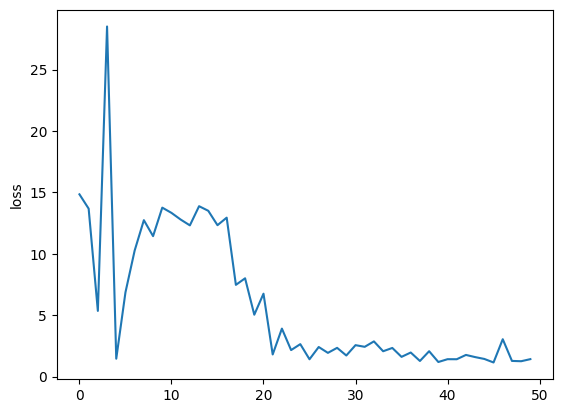

In [32]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

In [33]:
from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

In [34]:
# %load_ext tensorboard
%reload_ext tensorboard

In [36]:
%tensorboard --logdir=$LOG_DIR

## create inference dataset

> **TODO**

In [58]:
# def _serving_input_fn(input_features):
#   """Converts input features into Timestep for serving."""
#   global_features = _get_global_feature_list(input_features)
#   arm_features = _get_per_arm_feature_dict(input_features)

#   observation = {
#       utils.GLOBAL_FEATURE_KEY:
#           tf.concat(global_features, axis=1),
#       # Adds an num_action dimension.
#       utils.PER_ARM_FEATURE_KEY:
#           _add_outer_dimension(arm_features)
#   }
#   batch_size = tf.reshape(
#       tf.shape(observation[utils.GLOBAL_FEATURE_KEY])[0], [1])
#   return time_step.restart(observation=observation, batch_size=batch_size)